In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
# Define hyperparameters
INPUT_NEURONS = 784
OUTPUT_NEURONS = 10
HIDDEN_NEURONS = 200
LEARNING_RATE = 0.005
LAMBDA_REG = 0.01
BATCH_SIZE = 2000
DATA_SIZE = 40000

In [6]:
# Reading the data into numpy array
data_train = np.array(pd.read_csv("train.csv")) # shape 42000 x 785
# Shuffle the data
np.random.shuffle(data_train)
# ------------------------------- #
# Getting the first 40000 entries for training
Y_train = data_train[:DATA_SIZE, 0]  # Getting the label as the first column
X_train = data_train[:DATA_SIZE, 1:]  # The rest is data input
# ------------------------------- #
# The last 2000 entries are for testing
X_test = data_train[DATA_SIZE:, 1:]
Y_test = data_train[DATA_SIZE:, 0]

In [7]:
# Generating batches to feed the model
def get_batch():
    for i in range(DATA_SIZE // BATCH_SIZE):
        size = i * BATCH_SIZE
        data = data_train[size : size + BATCH_SIZE]
        Y_in = data[:, 0]
        X_in = data[:, 1:]
        yield X_in, Y_in

In [8]:
# Initializing parameters
def init_params(input_n, hidden_n, output_n):
    model_param = {}
    # Xavier Initialization
    model_param["W1"] = np.random.randn(input_n, hidden_n) / np.sqrt(input_n)
    model_param["b1"] = np.zeros((1, hidden_n))
    model_param["W2"] = np.random.randn(hidden_n, output_n) / np.sqrt(hidden_n)
    model_param["b2"] = np.zeros((1, output_n))
    return model_param

In [9]:
# Derivative of Tanh
def tanh_deriv(Z):
    return 1 - np.power(np.tanh(Z), 2)

In [10]:
# Calculating soft max
def soft_max(V):
    return np.exp(V) / np.sum(np.exp(V), axis=1, keepdims=True)

In [11]:
# Forward propagation
def forward_prop(X_in, model_param):
    """ X . W1 + b1 -> Z1
        tanh(Z1) -> A1
        A1 . W2 + b2 -> Z2
        soft_max(Z2) -> A2"""
    Z1 = X_in.dot(model_param["W1"]) + model_param["b1"]
    A1 = np.tanh(Z1)
    Z2 = A1.dot(model_param["W2"]) + model_param["b2"]
    A2 = soft_max(Z2)
    return Z1, A1, Z2, A2

In [12]:
# Back propagation
def backward_prop(X_in, Y_in, model_param, epochs):
    for i in range(epochs):
        Z1, A1, Z2, A2 = forward_prop(X_in, model_param)
        temp_A2 = np.copy(A2)
        temp_A2[np.arange(BATCH_SIZE), Y_in] -= 1
        dZ2 = temp_A2 # dL/dZ2
        dW2 = (A1.T).dot(dZ2) / float(BATCH_SIZE) # dL/dW2
        db2 = np.sum(dZ2, axis=0, keepdims=True) / float(BATCH_SIZE) # dL/db2
        dZ1 = dZ2.dot(model_param["W2"].T) * tanh_deriv(Z1) # dL/dZ1
        dW1 = np.dot(X_in.T, dZ1) / float(BATCH_SIZE) # dL/dW1
        db1 = np.sum(dZ1, axis=0, keepdims=True) / float(BATCH_SIZE) # dL/db1
        # Update the weight with L2 regularization
        dW2 += LAMBDA_REG * np.sum(model_param["W2"]) / float(BATCH_SIZE)
        dW1 += LAMBDA_REG * np.sum(model_param["W1"]) / float(BATCH_SIZE)
        # Optimizing parameters
        model_param["W1"] += -LEARNING_RATE * dW1
        model_param["W2"] += -LEARNING_RATE * dW2
        model_param["b1"] += -LEARNING_RATE * db1
        model_param["b2"] += -LEARNING_RATE * db2
        model_param["A2"] = A2
    return model_param

In [13]:
# Making prediction by feeding the test data
def make_predict(X_in, model_param):
    Z1, A1, Z2, A2 = forward_prop(X_in, model_param)
    return np.argmax(A2, axis=1)

In [14]:
# Main driver
model_param = init_params(INPUT_NEURONS, HIDDEN_NEURONS, OUTPUT_NEURONS)
input = get_batch()
for i in range(DATA_SIZE // BATCH_SIZE):
    X_in, Y_in = next(input)
    model_param = backward_prop(X_in, Y_in, model_param, 200)
    if i > 10:
        print(
            f"Train data Acc: {accuracy_score(np.argmax(model_param['A2'], axis = 1), Y_in)},\
            Test data Acc: {accuracy_score(make_predict(X_test, model_param), Y_test)}"
        )

Train data Acc: 0.9235,            Test data Acc: 0.8935
Train data Acc: 0.9235,            Test data Acc: 0.895
Train data Acc: 0.93,            Test data Acc: 0.896
Train data Acc: 0.9285,            Test data Acc: 0.9
Train data Acc: 0.93,            Test data Acc: 0.9065
Train data Acc: 0.9355,            Test data Acc: 0.9085
Train data Acc: 0.931,            Test data Acc: 0.9095
Train data Acc: 0.933,            Test data Acc: 0.9055
Train data Acc: 0.937,            Test data Acc: 0.9085


#### The accuracy with the test data is approximately 90%

In [16]:
# Showing the result of the prediction
def test_prediction(index, model_param):
    current_image = X_test[index, :, None]
    prediction = make_predict(X_test, model_param)
    label = Y_test[index]
    print(f"----- Prediction: {prediction[index]} -----")
    print("\tLabel: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation="nearest")
    plt.show()

----- Prediction: [0] -----
	Label:  [0]


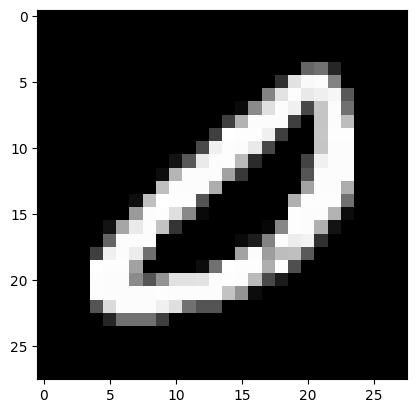

----- Prediction: [1] -----
	Label:  [1]


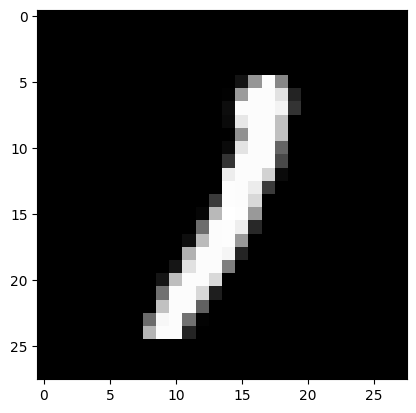

----- Prediction: [3] -----
	Label:  [3]


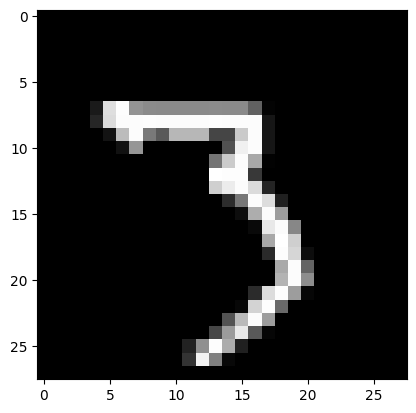

----- Prediction: [7] -----
	Label:  [7]


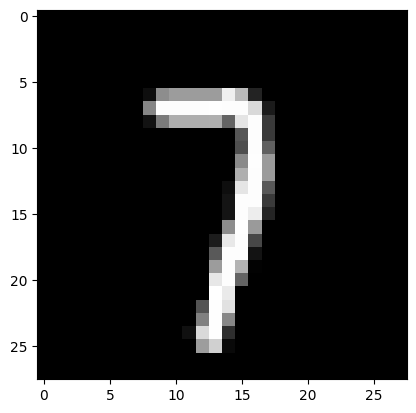

In [17]:
test_prediction(np.random.randint(low=0, high=BATCH_SIZE, size=1), model_param)
test_prediction(np.random.randint(low=0, high=BATCH_SIZE, size=1), model_param)
test_prediction(np.random.randint(low=0, high=BATCH_SIZE, size=1), model_param)
test_prediction(np.random.randint(low=0, high=BATCH_SIZE, size=1), model_param)